In [ ]:
# All imports
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm
from fastai.imports import *
from fastai.vision.all import *
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import SparseCategoricalCrossentropy
from tensorflow import keras
from PIL import Image
from numpy import asarray
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from scipy.io import loadmat 
import cv2
from tensorflow.keras.models import Model

In [ ]:
# Retrieving files from our Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Unzipping files into colab
!unzip '/content/drive/My Drive/NNDL Project Submission/im.zip'

Streaming output truncated to the last 5000 lines.
  inflating: im/image_06851.jpg      
  inflating: __MACOSX/im/._image_06851.jpg  
  inflating: im/image_07597.jpg      
  inflating: __MACOSX/im/._image_07597.jpg  
  inflating: im/image_06689.jpg      
  inflating: __MACOSX/im/._image_06689.jpg  
  inflating: im/image_01680.jpg      
  inflating: __MACOSX/im/._image_01680.jpg  
  inflating: im/image_01858.jpg      
  inflating: __MACOSX/im/._image_01858.jpg  
  inflating: im/image_03097.jpg      
  inflating: __MACOSX/im/._image_03097.jpg  
  inflating: im/image_02389.jpg      
  inflating: __MACOSX/im/._image_02389.jpg  
  inflating: im/image_04920.jpg      
  inflating: __MACOSX/im/._image_04920.jpg  
  inflating: im/image_03083.jpg      
  inflating: __MACOSX/im/._image_03083.jpg  
  inflating: im/image_04934.jpg      
  inflating: __MACOSX/im/._image_04934.jpg  
  inflating: im/image_01694.jpg      
  inflating: __MACOSX/im/._image_01694.jpg  
  inflating: im/image_06845.jpg     

In [ ]:
# Input for the labels of our images
labels = '/content/drive/My Drive/NNDL Project/imagelabels.mat'
image_labels = loadmat(labels)
image_labels.keys()

dict_keys(['__header__', '__version__', '__globals__', 'labels'])

In [ ]:
# Adding our image_labels into a dataframe to match with our images
df = pd.DataFrame()
labels = image_labels['labels'].transpose()
labels = labels -1
df = pd.DataFrame(labels, columns = ['image_label'])

In [ ]:
# Adding our image paths to our image_labels dataframe
image_path = []
for i in range (1,len(labels)+1):
  if i<10:
    x = '0000' + str(i)
  elif i<100:
    x = '000' + str(i)
  elif i<1000:
    x = '00' + str(i)
  elif i<10000:
    x = '0' + str(i)
  else:
    break
  image_path.append('/content/im/image_'+x+'.jpg')

df["image_path"] = image_path 

In [ ]:
# Checking how many images we have per class (top few and bottom few to understand the distributioin of samples)
df.image_label.value_counts()

50    258
76    251
45    196
72    194
88    184
     ... 
6      40
44     40
33     40
0      40
26     40
Name: image_label, Length: 102, dtype: int64

In [ ]:
# Test to see whether the path code works to open the 1st image
im = Image.open(df['image_path'][0])
width, height = im.size
print(width,height)

591 500


In [ ]:
# Final check on our data frame before loading the images and converting them to (size, size, 3) numpy pixels
df

,image_label,image_path
0,76,/content/im/image_00001.jpg
1,76,/content/im/image_00002.jpg
2,76,/content/im/image_00003.jpg
3,76,/content/im/image_00004.jpg
4,76,/content/im/image_00005.jpg
...,...,...
8184,61,/content/im/image_08185.jpg
8185,61,/content/im/image_08186.jpg
8186,61,/content/im/image_08187.jpg
8187,61,/content/im/image_08188.jpg


In [ ]:
# Function to load images, convert to numpy array of pixel data, split into train test split, convert to a tensor and return. (Based on img_size input)
def split_function(train_df,img_size):
    data = train_df.copy()
    img_size = img_size
    train_image = []
    for i in tqdm(range(data.shape[0])):
      # inputting images with the required input size
      img = image.load_img(data['image_path'][i],target_size=(img_size,img_size,3))
      img = image.img_to_array(img)
      train_image.append(img)
    # appending the image arrays to a new numpy array
    train_df = np.array(train_image)
    image_label = data['image_label'].to_numpy()
    # train, val, test split (0.7, 0.2, 0.1)
    X_train, X_test, y_train, y_test = train_test_split(train_df, image_label, random_state=42, test_size=0.3, stratify = image_label)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.33, stratify = y_test)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

    print('Number of training samples ', len(train_ds))
    print('Number of validation samples ', len(val_ds))

    # Batching and applying prefetching for faster processing
    train_ds = train_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    val_ds = val_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    print('Number of training samples after batching ', len(train_ds))
    print('Number of validation samples after batching ', len(val_ds))
    
    return(train_ds, val_ds)

In [ ]:
# Fetching all pretrained keras models
all_models_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

# List of all pretrained Keras Model
all_models_dictionary

{'DenseNet121': <function keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
 'DenseNet169': <function keras.applications.densenet.DenseNet169(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
 'DenseNet201': <function keras.applications.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
 'EfficientNetB0': <function keras.applications.efficientnet.EfficientNetB0(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax', **kwargs)>,
 'EfficientNetB1': <function keras.applications.efficientnet.EfficientNetB1(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None,

In [ ]:
# List of all pretrained Keras models specifically for image classification
image_pretrained_models = [
        'VGG16',
        'VGG19',
        'ResNet50',
        'ResNet50V2',
        'ResNet101',
        'ResNet101V2',
        'ResNet152',
        'ResNet152V2',
        'MobileNet',
        'MobileNetV2',
        'DenseNet121',
        'DenseNet169',
        'DenseNet201',
        'NASNetMobile',
        'EfficientNetB0',
        'EfficientNetB1',
        'EfficientNetB2',
        'EfficientNetB3',
        'EfficientNetB4',
        'EfficientNetB5',
        'EfficientNetB6',
        'EfficientNetB7',
        'EfficientNetV2B0',
        'EfficientNetV2B1',
        'EfficientNetV2B2',
        'EfficientNetV2B3',
        'EfficientNetV2S',
        'EfficientNetV2M',
        'EfficientNetV2L',
        'Xception',
        'InceptionV3',
        'InceptionResNetV2',
        'NASNetLarge'
    ]

In [ ]:
preprocess_func = { 'VGG16' : tf.keras.applications.vgg16.preprocess_input,
                    'VGG19':tf.keras.applications.vgg19.preprocess_input,
                    'ResNet50':tf.keras.applications.resnet.preprocess_input,
                    'ResNet50V2':tf.keras.applications.resnet_v2.preprocess_input,
                    'ResNet101':tf.keras.applications.resnet.preprocess_input,
                    'ResNet101V2':tf.keras.applications.resnet_v2.preprocess_input,
                    'ResNet152':tf.keras.applications.resnet.preprocess_input,
                    'ResNet152V2':tf.keras.applications.resnet_v2.preprocess_input,
                    'MobileNet':tf.keras.applications.mobilenet.preprocess_input,
                    'MobileNetV2':tf.keras.applications.mobilenet_v2.preprocess_input,
                    'DenseNet121':tf.keras.applications.densenet.preprocess_input,
                    'DenseNet169':tf.keras.applications.densenet.preprocess_input,
                    'DenseNet201':tf.keras.applications.densenet.preprocess_input,
                    'NASNetMobile':tf.keras.applications.nasnet.preprocess_input,
                    'EfficientNetB0':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB1':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB2':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB3':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB4':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB5':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB6':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetB7':tf.keras.applications.efficientnet.preprocess_input,
                    'EfficientNetV2B0':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2B1':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2B2':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2B3':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2S':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2M':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'EfficientNetV2L':tf.keras.applications.efficientnet_v2.preprocess_input,
                    'Xception': tf.keras.applications.xception.preprocess_input,
                    'InceptionV3':tf.keras.applications.inception_v3.preprocess_input,
                    'InceptionResNetV2':tf.keras.applications.inception_resnet_v2.preprocess_input,
                    'NASNetLarge':tf.keras.applications.nasnet.preprocess_input
                  }

In [ ]:
# Fetching only the models specifically mentioned for image classification
image_models = {image_pretrained_model: all_models_dictionary[image_pretrained_model] for image_pretrained_model in image_pretrained_models}

# Corresponds to Keras documentation for image specific pretrained models
len(image_models)

33

In [ ]:
# Early stopping implementation to reduce over
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Initialising our augmentation layer
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.2),
])

In [ ]:
train_ds, val_ds = split_function(df,224)

100%|██████████| 8189/8189 [00:40<00:00, 203.81it/s]


Number of training samples  5732
Number of validation samples  1646
Number of training samples after batching  180
Number of validation samples after batching  52


In [ ]:
# Using one model to conduct our fine tuning experiments
model = 'EfficientNetV2B2'

preprocess_func = tf.keras.applications.efficientnet_v2.preprocess_input

In [ ]:
# Visualising what fine tuning does to our best model

retrieved_model = keras.models.load_model('/content/drive/My Drive/NNDL Project Submission/trained_models/'+model)
# Unfreeze the base model
retrieved_model.trainable = True
#recompile the model 
retrieved_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#training the model again 
retrieved_model.summary()
history_fine_tuned = retrieved_model.fit(train_ds, epochs = 20, validation_data=val_ds, callbacks=[es])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_4 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b2 (Function  (None, 7, 7, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_4   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1408)              0   

Text(0, 0.5, 'Accuracy')

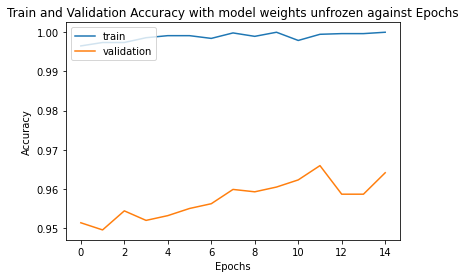

In [ ]:
plt.plot(history_fine_tuned.history["accuracy"])
plt.plot(history_fine_tuned.history["val_accuracy"])
plt.title('Train and Validation Accuracy with model weights unfrozen against Epochs')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

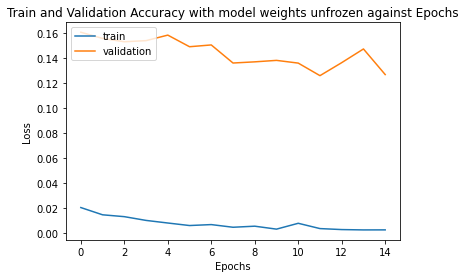

In [ ]:
plt.plot(history_fine_tuned.history["loss"])
plt.plot(history_fine_tuned.history["val_loss"])
plt.title('Train and Validation Accuracy with model weights unfrozen against Epochs')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
# Therefore from the plots we can see that there is overfitting happening when running the models with unfreezing the base weights at a high number of epochs

In [ ]:
retrieved_model = keras.models.load_model('/content/drive/My Drive/NNDL Project Submission/trained_models_batch_normal/'+model)

retrieved_model.trainable = True
#recompile the model 
retrieved_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#training the model again 
retrieved_model.summary()
history_fine_tuned = retrieved_model.fit(train_ds, epochs = 20, validation_data=val_ds, callbacks=[es])



Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_9 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b2 (Function  (None, 7, 7, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_9   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_11 (Dropout)        (None, 1408)              0   

Text(0, 0.5, 'Accuracy')

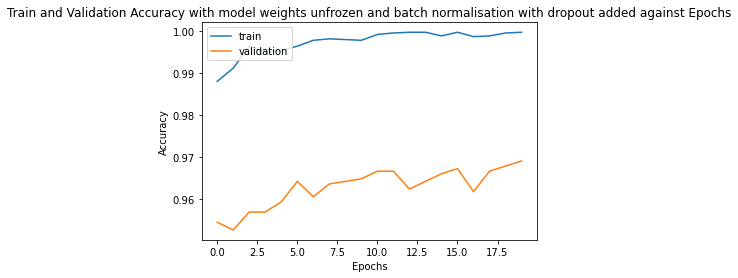

In [ ]:
plt.plot(history_fine_tuned.history["accuracy"])
plt.plot(history_fine_tuned.history["val_accuracy"])
plt.title('Train and Validation Accuracy with model weights unfrozen and batch normalisation with dropout added against Epochs')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

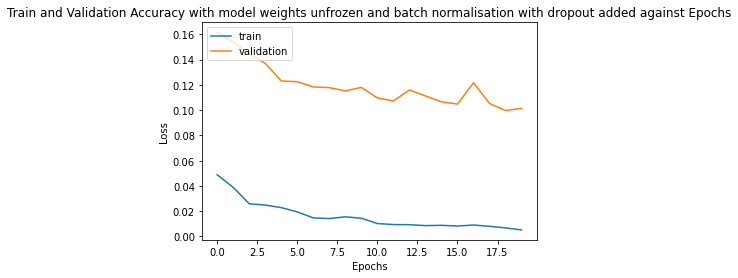

In [ ]:
plt.plot(history_fine_tuned.history["loss"])
plt.plot(history_fine_tuned.history["val_loss"])
plt.title('Train and Validation Accuracy with model weights unfrozen and batch normalisation with dropout added against Epochs')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
# From the plot above it can be seen that with the batch normalization it gives us a better more reduced loss

In [ ]:
top_5_models = []
pre_trained = pd.read_csv('/content/drive/My Drive/NNDL Project Submission/transfer_learning_model_results_pure.csv')
for i in tqdm(range(5)):
  top_5_models.append(pre_trained['pretrained_model_name'][i])

100%|██████████| 5/5 [00:00<00:00, 2135.81it/s]


In [ ]:
top_5_models

['EfficientNetV2B2',
 'EfficientNetB2',
 'EfficientNetB1',
 'EfficientNetV2B1',
 'DenseNet201']

In [ ]:
fine_model_benchmarks = {'pretrained_model_name' : [], 'num_params' : [], 'validation_accuracy' : [] }

for model in top_5_models:
  retrieved_model = keras.models.load_model('/content/drive/My Drive/NNDL Project Submission/trained_models_batch_normal/'+model)
  # Unfreeze the base model
  retrieved_model.trainable = True
  #recompile the model 
  retrieved_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  #training the model again 
  retrieved_model.summary()
  history_fine_tuned = retrieved_model.fit(train_ds, epochs = 25, validation_data=val_ds, callbacks=[es])

  retrieved_model.save('/content/drive/My Drive/NNDL Project Submission/trained_finetuned_models/'+model)
  retrieved_model.save(model)

  fine_model_benchmarks['pretrained_model_name'].append(model)
  fine_model_benchmarks['num_params'].append(retrieved_model.count_params())
  fine_model_benchmarks['validation_accuracy'].append(history_fine_tuned.history['val_accuracy'][-1])

  plt.plot(history_fine_tuned.history["accuracy"])
  plt.plot(history_fine_tuned.history["val_accuracy"])
  plt.title('Train and Validation Accuracy with best learning rate against Epochs')
  plt.legend(['train', 'validation'], loc = 'upper left')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.savefig(model+'finetuned_accuracy.png')

  plt.clf()

  plt.plot(history_fine_tuned.history["loss"])
  plt.plot(history_fine_tuned.history["val_loss"])
  plt.title('Train and Validation Accuracy with best learning rate against Epochs')
  plt.legend(['train', 'validation'], loc = 'upper left')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.savefig(model+'finetuned_loss.png')

  plt.clf()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_9 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b2 (Function  (None, 7, 7, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_9   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_11 (Dropout)        (None, 1408)              0   

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_10 (TFOpLambda)     (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 global_average_pooling2d_10  (None, 1408)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_13 (Dropout)        (None, 1408)              0         
                                                          

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_11 (TFOpLambda)     (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d_11  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_15 (Dropout)        (None, 1280)              0         
                                                          

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_12 (TFOpLambda)     (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 7, 7, 1280)       6931124   
 al)                                                             
                                                                 
 global_average_pooling2d_12  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_17 (Dropout)        (None, 1280)              0  

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_13 (TFOpLambda)     (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 224, 224, 3)      0  

<Figure size 432x288 with 0 Axes>

In [ ]:
# Converting model benchmarks to a DataFrame
benchmark_df = pd.DataFrame(fine_model_benchmarks)
benchmark_df

,pretrained_model_name,num_params,validation_accuracy
0,EfficientNetV2B2,9157316,0.965371
1,EfficientNetB2,8156511,0.965978
2,EfficientNetB1,6930413,0.962333
3,EfficientNetV2B1,7286298,0.953827
4,DenseNet201,18840998,0.956258
